# Zebrahub Data Loading & Exploration

This notebook loads light sheet microscopy data of zebrafish embryos from [Zebrahub](https://zebrahub.sf.czbiohub.org/), a comprehensive atlas of zebrafish development.

The data is stored as **OME-Zarr** on a public HTTP server. We load it lazily with `zarr` + `dask` so only the slices we request are downloaded — no need to download the full dataset.

We start with **ZSNS001_tail**, a cropped region of the tail from a single-objective DaXi light sheet acquisition with a Histone-mCherry nuclear marker.

In [1]:
import zarr
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
from ome_zarr.io import parse_url
from ome_zarr.reader import Reader

## 1. Load the remote OME-Zarr dataset

The data lives at `public.czbiohub.org`. Opening it creates a lazy dask array — no data is downloaded until we call `.compute()` on a slice.

In [2]:
URL = "https://public.czbiohub.org/royerlab/zebrahub/imaging/single-objective/ZSNS001_tail.ome.zarr"

reader = Reader(parse_url(URL))
nodes = list(reader())

# Each node contains a list of dask arrays, one per resolution level
dask_data = nodes[0].data
print(f"Number of resolution levels: {len(dask_data)}")
for i, arr in enumerate(dask_data):
    print(f"  Level {i}: shape={arr.shape}, dtype={arr.dtype}, chunks={arr.chunksize}")

version mismatch: detected: FormatV04, requested: FormatV05


Number of resolution levels: 3
  Level 0: shape=(791, 1, 420, 1217, 1091), dtype=uint16, chunks=(1, 1, 128, 362, 362)
  Level 1: shape=(791, 1, 210, 609, 546), dtype=uint16, chunks=(1, 1, 128, 362, 362)
  Level 2: shape=(791, 1, 105, 305, 273), dtype=uint16, chunks=(1, 1, 105, 305, 273)


In [3]:
# Use full resolution (level 0) as our primary data
data = dask_data[0]
print(f"Full resolution shape (T, C, Z, Y, X): {data.shape}")
print(f"Dtype: {data.dtype}")

n_timepoints, n_channels, n_z, n_y, n_x = data.shape
print(f"\nTimepoints: {n_timepoints}")
print(f"Channels: {n_channels}")
print(f"Volume per timepoint: {n_z} x {n_y} x {n_x} voxels")

Full resolution shape (T, C, Z, Y, X): (791, 1, 420, 1217, 1091)
Dtype: uint16

Timepoints: 791
Channels: 1
Volume per timepoint: 420 x 1217 x 1091 voxels


## 2. Inspect OME-Zarr metadata

The OME-Zarr `.zattrs` contains voxel sizes, axis labels, and channel info.

In [4]:
# Read metadata directly from the zarr store
import fsspec
store = fsspec.get_mapper(URL)
root = zarr.open_group(store, mode="r")
attrs = dict(root.attrs)

# Extract voxel sizes from the coordinate transformations
multiscales = attrs["multiscales"][0]
axes = multiscales["axes"]
print("Axes:")
for ax in axes:
    print(f"  {ax['name']} ({ax['type']})")

# Voxel size at full resolution
scale = multiscales["datasets"][0]["coordinateTransformations"][0]["scale"]
print(f"\nVoxel size (T, C, Z, Y, X): {scale}")
print(f"Physical voxel size: {scale[2]:.3f} x {scale[3]:.3f} x {scale[4]:.3f} µm (Z x Y x X)")

# Channel info
if "omero" in attrs:
    channels = attrs["omero"]["channels"]
    for ch in channels:
        print(f"\nChannel: {ch['label']}")
        print(f"  Display range: {ch['window']['start']} - {ch['window']['end']}")
        print(f"  Full range: {ch['window']['min']} - {ch['window']['max']}")

Axes:
  t (time)
  c (channel)
  z (space)
  y (space)
  x (space)

Voxel size (T, C, Z, Y, X): [1.0, 1.0, 1.24, 0.439, 0.439]
Physical voxel size: 1.240 x 0.439 x 0.439 µm (Z x Y x X)

Channel: fused
  Display range: 0 - 1500
  Full range: 0 - 65535


## 3. Visualize orthogonal cross-sections

Pull single XY, XZ, and YZ slices from the middle of the volume at the first timepoint.

In [5]:
t = 0  # first timepoint
c = 0  # first (only) channel

# Take slices through the middle of each axis
mid_z = n_z // 2
mid_y = n_y // 2
mid_x = n_x // 2

print(f"Loading 3 orthogonal slices at t={t}...")
xy_slice = data[t, c, mid_z, :, :].compute()   # XY plane
xz_slice = data[t, c, :, mid_y, :].compute()   # XZ plane
yz_slice = data[t, c, :, :, mid_x].compute()   # YZ plane
print("Done.")

# Shared display range (1st–99.5th percentile) for all visualizations
all_pixels = np.concatenate([xy_slice.ravel(), xz_slice.ravel(), yz_slice.ravel()])
vmin, vmax = np.percentile(all_pixels, [1, 99.5])
print(f"Display range (p1–p99.5): {vmin:.0f} – {vmax:.0f}")

Loading 3 orthogonal slices at t=0...
Done.
Display range (p1–p99.5): 0 – 42


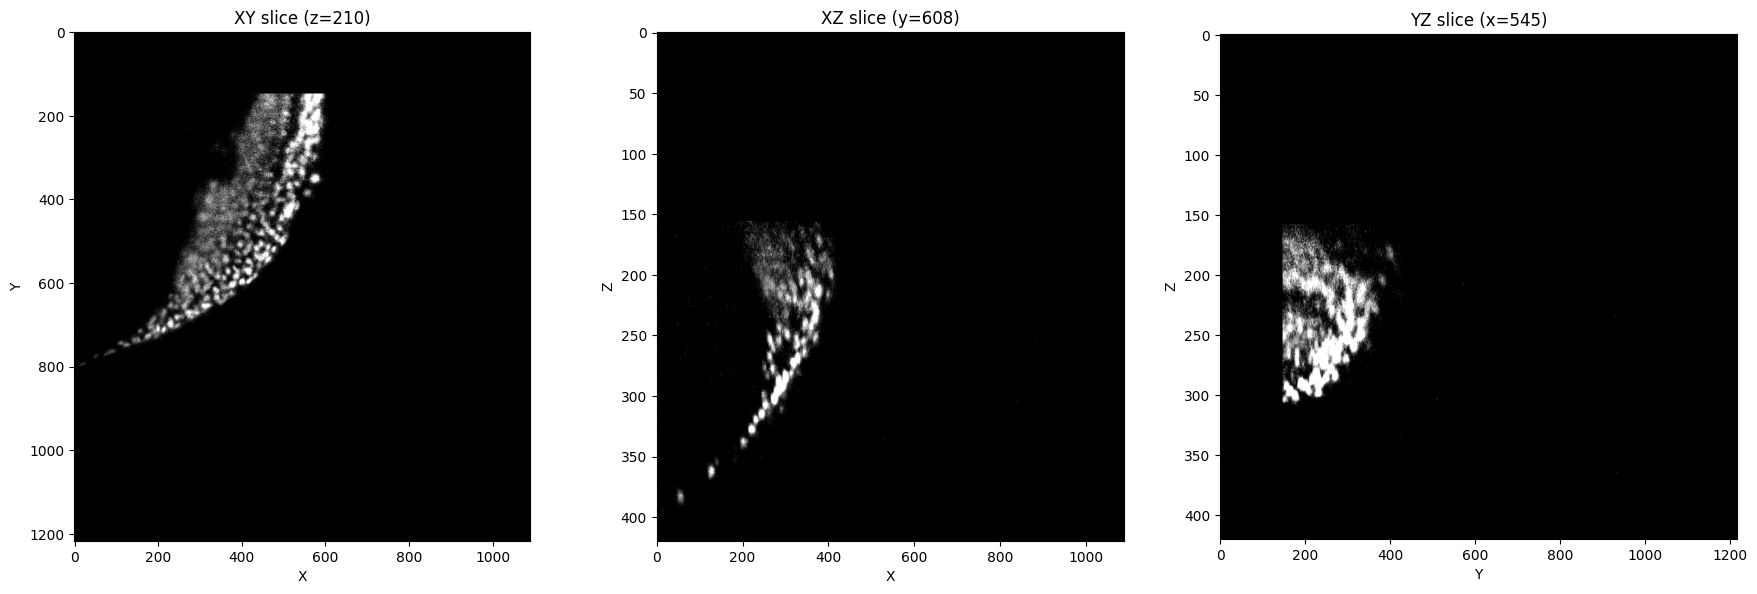


Intensity stats (XY slice):
  min=0, max=115, mean=1.4, std=5.8


In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(xy_slice, cmap="gray", vmin=vmin, vmax=vmax)
axes[0].set_title(f"XY slice (z={mid_z})")
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")

axes[1].imshow(xz_slice, cmap="gray", aspect=scale[2]/scale[4], vmin=vmin, vmax=vmax)
axes[1].set_title(f"XZ slice (y={mid_y})")
axes[1].set_xlabel("X")
axes[1].set_ylabel("Z")

axes[2].imshow(yz_slice, cmap="gray", aspect=scale[2]/scale[3], vmin=vmin, vmax=vmax)
axes[2].set_title(f"YZ slice (x={mid_x})")
axes[2].set_xlabel("Y")
axes[2].set_ylabel("Z")

plt.tight_layout()
plt.show()

print(f"\nIntensity stats (XY slice):")
print(f"  min={xy_slice.min()}, max={xy_slice.max()}, mean={xy_slice.mean():.1f}, std={xy_slice.std():.1f}")


## 4. Explore across timepoints

Sample a few timepoints evenly spaced across the timelapse to see how the embryo develops.

Loading t=0... Loading t=112... Loading t=225... Loading t=338... Loading t=451... Loading t=564... Loading t=677... Loading t=790... Done.


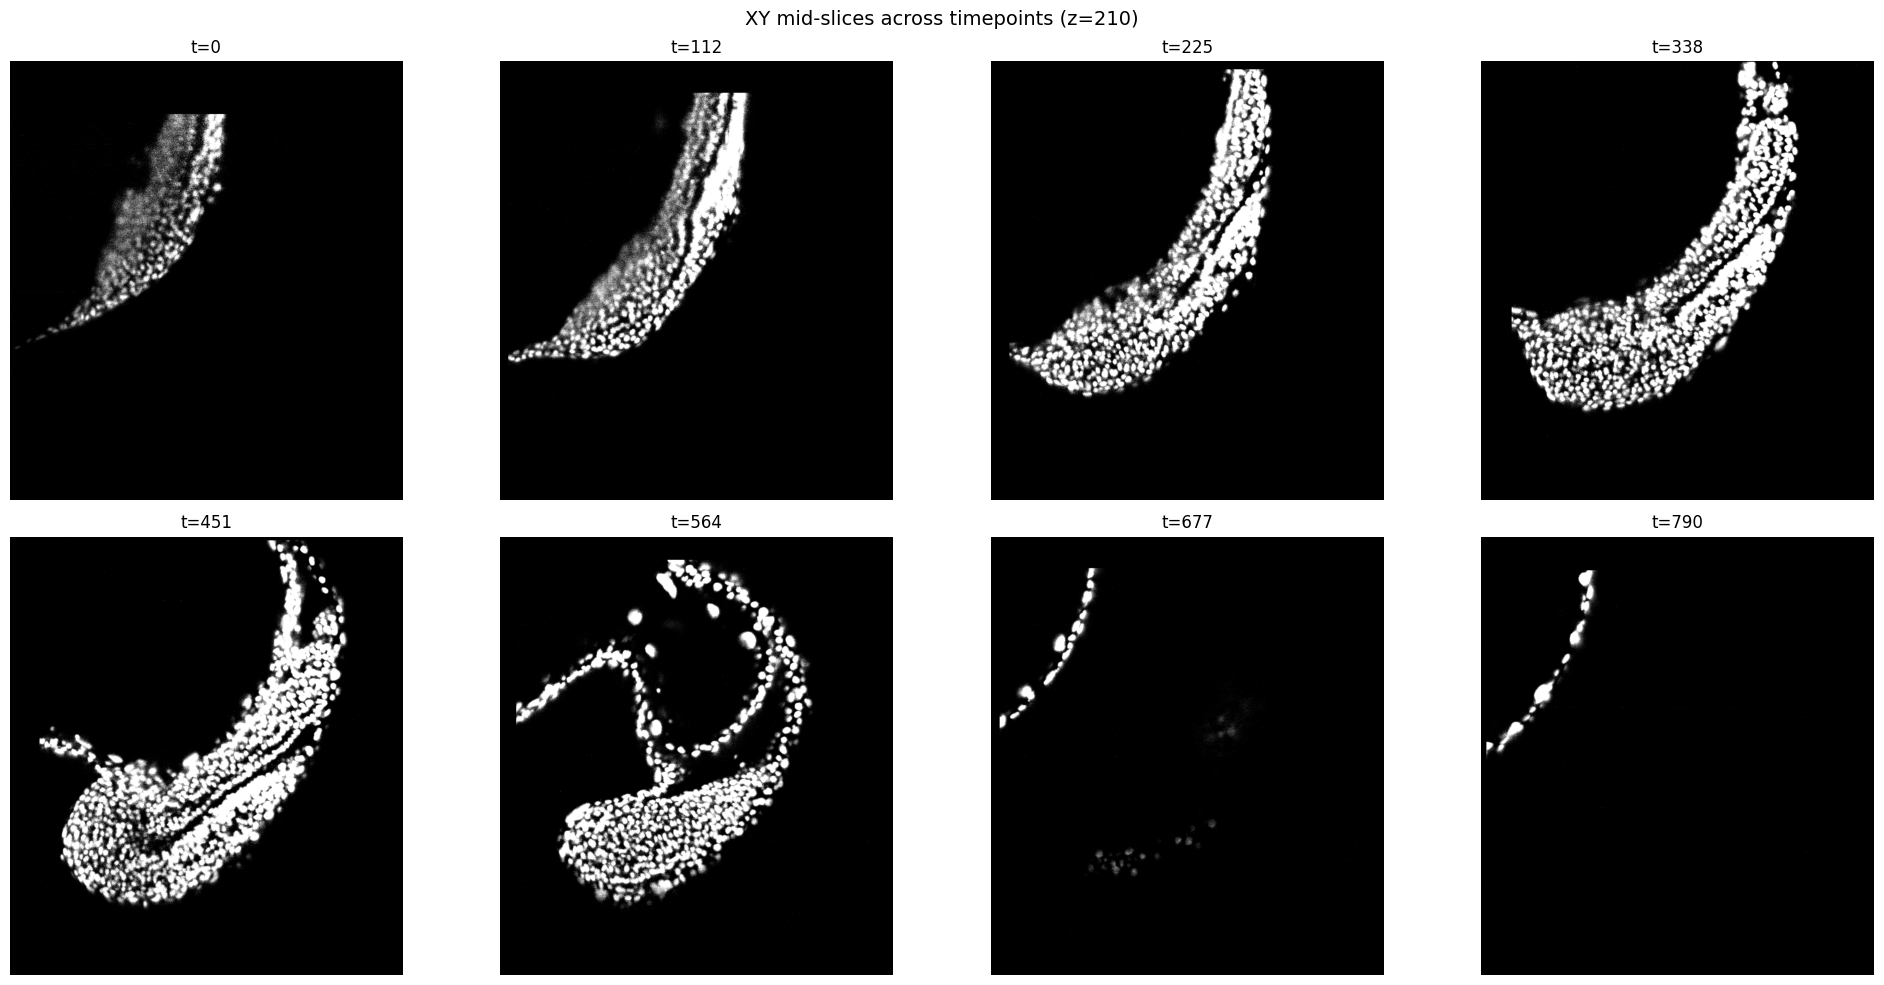

In [7]:
# Pick up to 8 evenly spaced timepoints
n_samples = min(8, n_timepoints)
sample_times = np.linspace(0, n_timepoints - 1, n_samples, dtype=int)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, t_idx in enumerate(sample_times):
    if i >= len(axes):
        break
    print(f"Loading t={t_idx}...", end=" ")
    slc = data[t_idx, 0, mid_z, :, :].compute()
    axes[i].imshow(slc, cmap="gray", vmin=vmin, vmax=vmax)
    axes[i].set_title(f"t={t_idx}")
    axes[i].axis("off")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

print("Done.")
plt.suptitle(f"XY mid-slices across timepoints (z={mid_z})", fontsize=14)
plt.tight_layout()
plt.show()

## 5. Browse z-slices at a single timepoint

View multiple z-slices to understand the 3D structure of the volume.

Loading z=0... Loading z=27... Loading z=55... Loading z=83... Loading z=111... Loading z=139... Loading z=167... Loading z=195... Loading z=223... Loading z=251... Loading z=279... Loading z=307... Loading z=335... Loading z=363... Loading z=391... Loading z=419... Done.


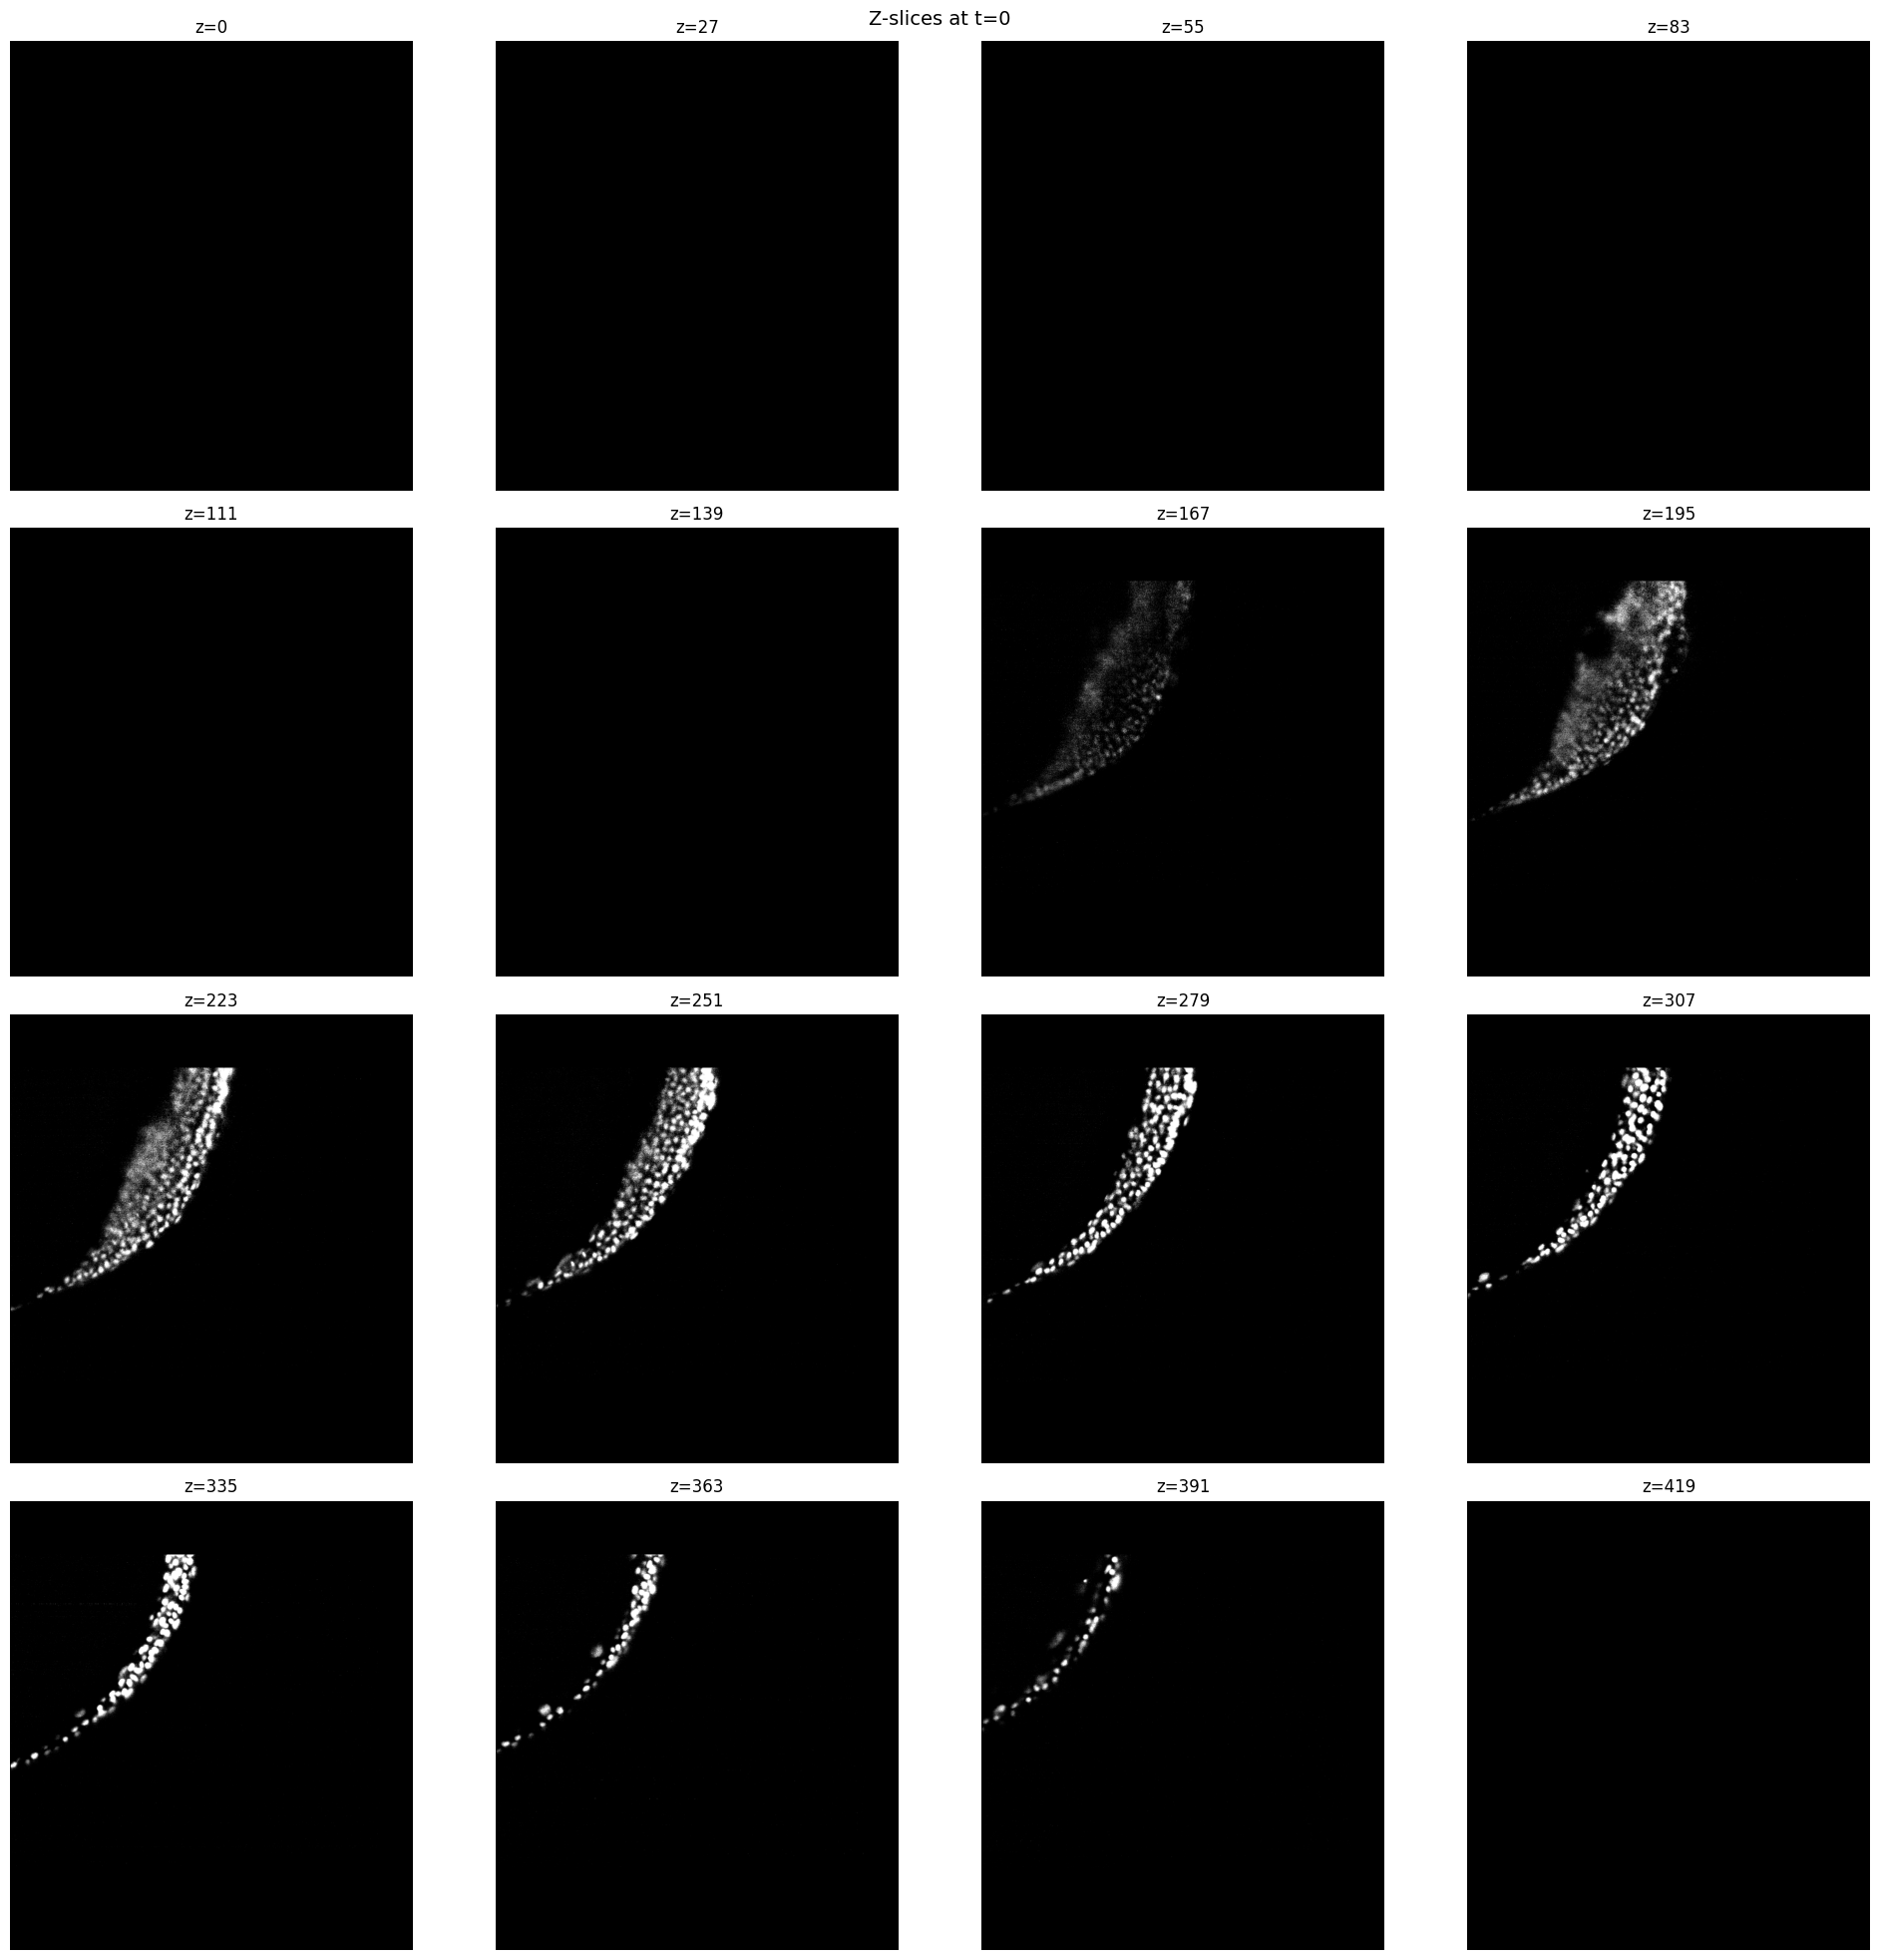

In [10]:
n_z_samples = min(16, n_z)
sample_zs = np.linspace(0, n_z - 1, n_z_samples, dtype=int)

fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

t_idx = 0
for i, z_idx in enumerate(sample_zs):
    if i >= len(axes):
        break
    print(f"Loading z={z_idx}...", end=" ")
    slc = data[t_idx, 0, z_idx, :, :].compute()
    axes[i].imshow(slc, cmap="gray", vmin=vmin, vmax=vmax)
    axes[i].set_title(f"z={z_idx}")
    axes[i].axis("off")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

print("Done.")
plt.suptitle(f"Z-slices at t={t_idx}", fontsize=14)
plt.tight_layout()
plt.show()

## 6. Extract 2D training patches

For the U-Net, we'll train on 2D XY patches. Here we demonstrate extracting random patches and caching them locally.

**Note:** The Zebrahub OME-Zarr files contain only the raw fluorescence images — segmentation labels are not included. We'll need to either:
- Use the Ultrack-related data at `public.czbiohub.org/royerlab/ultrack/` which includes a dense nuclear-labeled zebrafish embryo
- Generate our own labels (e.g., with classical methods like Otsu thresholding + watershed) as initial training targets

For now, let's just extract and examine raw image patches.

In [11]:
PATCH_SIZE = 256

def extract_random_patches(data, t, c, z, n_patches=4, patch_size=PATCH_SIZE, seed=42):
    """Extract random 2D XY patches from a given (t, c, z) slice."""
    rng = np.random.default_rng(seed)
    _, _, _, h, w = data.shape

    # Load the full slice once
    full_slice = data[t, c, z, :, :].compute()

    patches = []
    coords = []
    for _ in range(n_patches):
        y0 = rng.integers(0, h - patch_size)
        x0 = rng.integers(0, w - patch_size)
        patch = full_slice[y0:y0 + patch_size, x0:x0 + patch_size]
        patches.append(patch)
        coords.append((y0, x0))

    return patches, coords, full_slice


patches, coords, full_slice = extract_random_patches(data, t=0, c=0, z=mid_z)
print(f"Extracted {len(patches)} patches of size {PATCH_SIZE}x{PATCH_SIZE}")

Extracted 4 patches of size 256x256


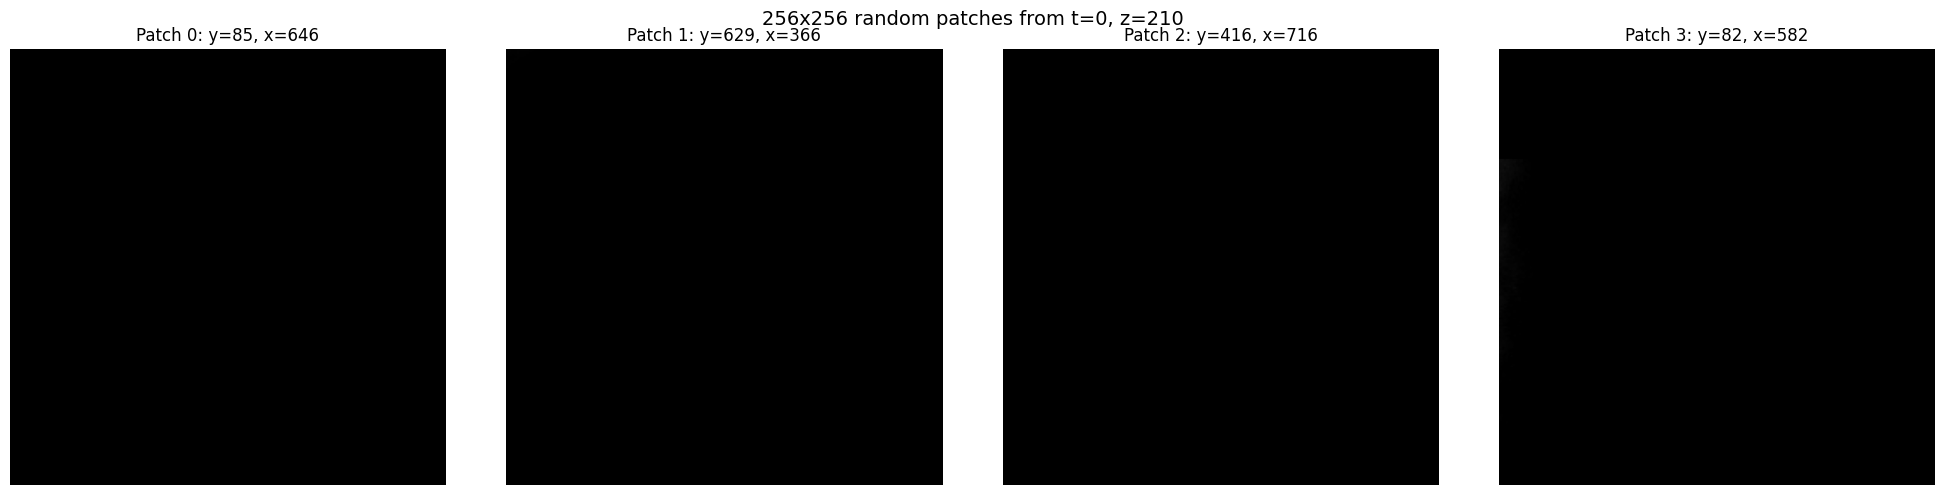

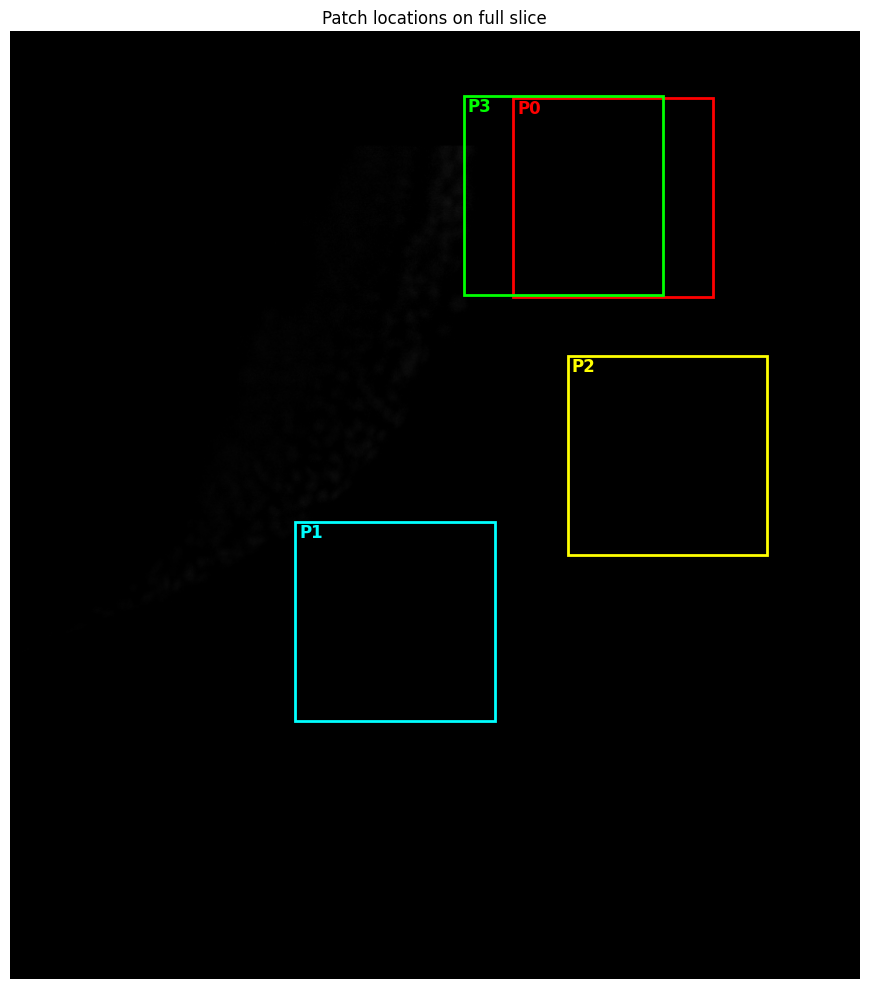

In [ ]:
fig, axes = plt.subplots(1, len(patches), figsize=(5 * len(patches), 5))

for i, (patch, (y0, x0)) in enumerate(zip(patches, coords)):
    axes[i].imshow(patch, cmap="gray", vmin=0, vmax=1500)
    axes[i].set_title(f"Patch {i}: y={y0}, x={x0}")
    axes[i].axis("off")

plt.suptitle(f"{PATCH_SIZE}x{PATCH_SIZE} random patches from t=0, z={mid_z}", fontsize=14)
plt.tight_layout()
plt.show()

# Show where patches came from on the full slice
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(full_slice, cmap="gray", vmin=vmin, vmax=vmax)
colors = ["red", "cyan", "yellow", "lime"]
for i, (y0, x0) in enumerate(coords):
    rect = plt.Rectangle((x0, y0), PATCH_SIZE, PATCH_SIZE,
                          linewidth=2, edgecolor=colors[i % len(colors)], facecolor="none")
    ax.add_patch(rect)
    ax.text(x0 + 5, y0 + 20, f"P{i}", color=colors[i % len(colors)], fontsize=12, fontweight="bold")
ax.set_title("Patch locations on full slice")
ax.axis("off")
plt.tight_layout()
plt.show()

## 7. Save patches locally (optional)

Save extracted patches to a local `data/` directory for faster reuse.

In [ ]:
import os

save_dir = "../data/patches"
os.makedirs(save_dir, exist_ok=True)

for i, patch in enumerate(patches):
    path = os.path.join(save_dir, f"patch_t0_z{mid_z}_{i}.npy")
    np.save(path, patch)
    print(f"Saved {path} — shape={patch.shape}, dtype={patch.dtype}")

print(f"\nAll patches saved to {os.path.abspath(save_dir)}")

## Next steps

- **Ground truth labels:** Explore the Ultrack dataset at `public.czbiohub.org/royerlab/ultrack/` which includes `zebrafish_embryo.ome.zarr` with dense nuclear labels
- **Preprocessing:** Normalize intensities, apply CLAHE or other contrast enhancement
- **U-Net training:** Build a PyTorch dataset/dataloader from these patches paired with segmentation labels
- **Temporal splits:** Define train/val/test splits across developmental stages